In [5]:
%load_ext autoreload
%autoreload 2
from sklearn import tree
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv('data/data_processed.csv')

## Preprocess
Convert string columns to categorial codes

In [7]:
string_cols = ['survey_language', 'disability']
df[string_cols] = df[string_cols].astype('category')
df[string_cols] = df[string_cols].apply(lambda x: x.cat.codes)

In [8]:
candidate_cols = [
#      'travel_date_dow',
     'o_purpose_category',
     'd_purpose_category',
#      'num_non_hh_travelers',
#      'num_hh_travelers',
     'num_travelers',
#      'o_location_type',
#      'd_location_type',
#      'o_congestion',
     'd_congestion',
#      'age',
#      'employment',
#      'student',
     'license',
#      'planning_apps',
#      'industry',
#      'gender',
#      'education',
#      'survey_language',
#      'num_bicycles',
     'num_vehicles',
#      'res_type',
     'rent_own',
#      'income_aggregate',
#      'num_people',
#      'num_adults',
#      'num_kids',
#      'num_workers',
#      'num_students',
#      'disability'
#     'trip_distance'
]


categorial_columns = ['travel_date_dow', 'o_purpose_category', 'd_purpose_category', 'o_location_type',
                      'd_location_type', 'age', 'employment', 'license', 'planning_apps', 'industry',
                      'gender', 'survey_language', 'res_type', 'rent_own',  'disability']

onehot = pd.get_dummies(df[candidate_cols], columns=[x for x in categorial_columns if x in candidate_cols])


## Use decision tree to regress trip distance

In [9]:
X = onehot.to_numpy()
y = df['trip_distance'].to_numpy()
group = df['person_id'].to_numpy()

In [6]:
# Use small subset of data to see if it can overfit.
# X = X[:10000]
# y = y[:10000]
# group = group[:10000]

From the output of the following cell, we can see that the result are not good. The mean square error is still 

In [18]:
from utils import k_fold_cross_validation_regression
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(min_samples_leaf=150).fit(X, y)
train_metrics, val_metrics = k_fold_cross_validation_regression(X, y, group, model)


In [19]:
metrics = np.concatenate((train_metrics, val_metrics), axis=1)
metrics = metrics[:,[0, 3, 1, 4, 2, 5]]
train_metrics_df = pd.DataFrame(metrics, columns=['mse-train', 'mse-val', 'mae-train', 'mae-val', 'mape-train', 'mape-val'])
train_metrics_df


,mse-train,mse-val,mae-train,mae-val,mape-train,mape-val
0,11.375746,12.774366,2.323997,2.440108,4.168767,3.976369
1,11.812919,11.088689,2.375183,2.383896,4.168815,4.680619
2,11.505155,12.290905,2.344075,2.399999,4.137737,4.249327
3,11.601065,11.921187,2.345903,2.354865,4.157181,4.018988
4,11.736962,11.406311,2.376366,2.373096,4.238133,4.382177


In [20]:
train_metrics_df.to_csv('stats/decision_tree_distance.csv')

### Parameter search


In [17]:
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV, GroupKFold

distributions = {
    'min_samples_leaf': range(50, 450, 50),
}

k_fold = GroupKFold(n_splits=5)
search = RandomizedSearchCV(model,
                            distributions,
                            random_state=1,
                            n_jobs=4,
                            scoring='neg_mean_squared_error', # 'neg_mean_squared_error' or 'neg_mean_absolute_percentage_error'
                            n_iter=10,
                            cv=k_fold
                           ).fit(X, y, groups=group)
print('best parameter', search.best_params_)
print('best score', search.best_score_)


/Users/pinyen/opt/anaconda3/envs/da-ml/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best parameter {'min_samples_leaf': 150}
best score -11.896291571120177


The results are not good. It does not perform significantly better than the variance of the ground truth (note: the variance would be the mse for a model outputting the mean value for every input)

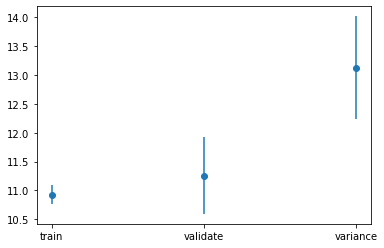

In [55]:
import matplotlib.pyplot as plt

mse_avg = np.average(np.array(mse), axis=0)
mse_std = np.std(np.array(mse), axis=0)
plt.xticks([0, 1, 2], ['train', 'validate', 'variance'])
plt.errorbar([0, 1, 2], mse_avg, yerr=mse_std, linestyle='None', marker='o')
plt.show()

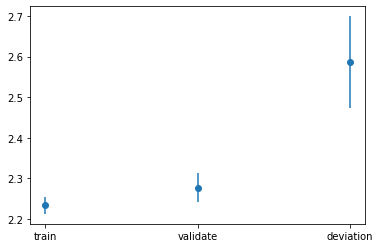

In [56]:
import matplotlib.pyplot as plt

mae_avg = np.average(np.array(mae), axis=0)
mae_std = np.std(np.array(mae), axis=0)
plt.xticks([0, 1, 2], ['train', 'validate', 'deviation'])
plt.errorbar([0, 1, 2], mae_avg, yerr=mae_std, linestyle='None', marker='o')
plt.show()

### Apply decision tree classifier to classify trip length
Let's try with a decision tree classifier.

In [57]:
# important_cols = ['d_congestion', 'd_purpose_category', 'num_vehicles', 'res_type', 'o_purpose_category',
#                   'income_aggregate']
X = onehot.to_numpy()
y = df['trip_distance_category'].to_numpy()
group = df['person_id'].to_numpy()

In [58]:
from sklearn.metrics import precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

k_fold = GroupKFold(n_splits=5)

for i, (train_idx, validate_idx) in enumerate(k_fold.split(X, y, groups=group)):
    print(f'train size: {len(train_idx)}, validation size: {len(validate_idx)}')
    
    X_train, X_val = X[train_idx], X[validate_idx]
    y_train, y_val = y[train_idx], y[validate_idx]
    
    model = DecisionTreeClassifier(max_depth=5).fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    
    print('training/validation precision: {:.2f} / {:.2f}'.format(
        precision_score(y_pred_train, y_train, average='micro'),
        precision_score(y_pred_val, y_val, average='micro'),
    ))
    
    labels = ['short', 'medium', 'long']
    confusion = confusion_matrix(y_val, y_pred_val, labels=labels, normalize='pred')
    confusion_df = pd.DataFrame(confusion, index=[x + '-label' for x in labels], columns=[x + '-pred' for x in labels])
    print('confusion matrix')
    with pd.option_context('display.float_format', '{:0.2f}'.format):
        print(confusion_df)
#     with np.printoptions(precision=2, suppress=True):
#         print(confusion)
    
#     if i == 0:
#         plt.figure()
#         tree.plot_tree(model)
#         plt.savefig('tree.eps',format='eps',bbox_inches = "tight")

    
    print('')


train size: 31555, validation size: 7889
training/validation precision: 0.47 / 0.47
confusion matrix
              short-pred  medium-pred  long-pred
short-label         0.52         0.28       0.13
medium-label        0.33         0.40       0.27
long-label          0.15         0.31       0.60

train size: 31555, validation size: 7889
training/validation precision: 0.47 / 0.49
confusion matrix
              short-pred  medium-pred  long-pred
short-label         0.56         0.31       0.10
medium-label        0.30         0.40       0.31
long-label          0.14         0.29       0.59

train size: 31555, validation size: 7889
training/validation precision: 0.48 / 0.46
confusion matrix
              short-pred  medium-pred  long-pred
short-label         0.52         0.32       0.16
medium-label        0.33         0.37       0.25
long-label          0.14         0.31       0.59

train size: 31555, validation size: 7889
training/validation precision: 0.48 / 0.46
confusion matrix
     

### Apply decision tree to classify mode choice

In [63]:
X = onehot.to_numpy()
y = df['mode']

train size: 31555, validation size: 7889
training/validation precision: 0.68 / 0.66

train size: 31555, validation size: 7889
training/validation precision: 0.68 / 0.66

train size: 31555, validation size: 7889
training/validation precision: 0.67 / 0.67

train size: 31555, validation size: 7889
training/validation precision: 0.69 / 0.65

train size: 31556, validation size: 7888
training/validation precision: 0.68 / 0.66



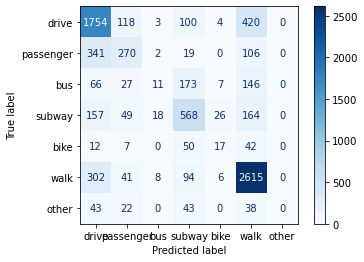

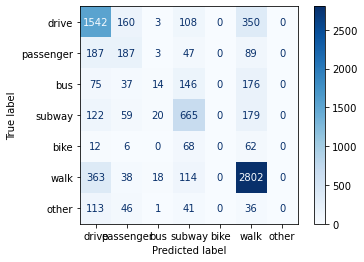

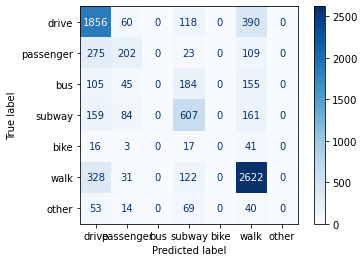

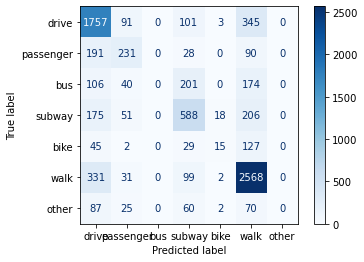

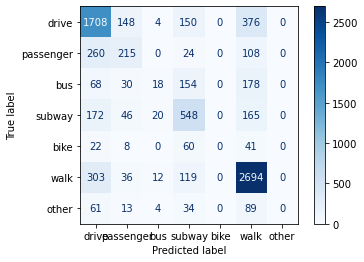

In [66]:
TRANSPORT_MODES = ['drive', 'passenger', 'bus', 'subway', 'bike', 'walk', 'other']

k_fold = GroupKFold(n_splits=5)

confusion = None
for train_idx, validate_idx in k_fold.split(X, y, groups=group):
    print(f'train size: {len(train_idx)}, validation size: {len(validate_idx)}')
    
    X_train, X_val = X[train_idx], X[validate_idx]
    y_train, y_val = y[train_idx], y[validate_idx]
    
    model = DecisionTreeClassifier(min_samples_leaf=200).fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    
    print('training/validation precision: {:.2f} / {:.2f}'.format(
        precision_score(y_pred_train, y_train, average='micro'),
        precision_score(y_pred_val, y_val, average='micro'),
    ))
    
    
    print('')
    
    display = ConfusionMatrixDisplay.from_predictions(
        y_val,
        y_pred_val,
        labels=TRANSPORT_MODES,
        values_format= 'd', 
        cmap=plt.cm.Blues
    )